In [ ]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import math
import cvxpy as cp

from decentr_quad_constraint_20node import *
import ciropt as co

: 

In [2]:
# random seed
np.random.seed(108)

# data generation
problem_spec = {}
problem_spec['n_node'] = 20
problem_spec['vector_size'] = 50
problem_spec['sc_theta'] = 0.5
problem_spec['sc_perturb'] = False
# problem_spec['sc_index_set'] = set(range(0, 10))
problem_spec['sc_index_set'] = set(range(0, 20))
# problem_spec['sc_index_set'] = {}
print(problem_spec)

problem_data = data_generation(problem_spec)
network_data = graph_generation(problem_spec['n_node'])
problem_data['itr_num'] = 1000


{'n_node': 20, 'vector_size': 50, 'sc_theta': 0.5, 'sc_perturb': False, 'sc_index_set': {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19}}


In [3]:
Q = problem_data['Q']
p = problem_data['p']
a = problem_data['a']
b = problem_data['b']
n_node = problem_spec['n_node']
vector_size = problem_spec['vector_size']
sc_index_set = problem_spec['sc_index_set']

for j in range(n_node):
    U, s, V = np.linalg.svd(Q[j])
    print([np.max(s), np.average(s), np.min(s)])

[8.230163554671448, 2.4213015102519986, 2.6701282076881496e-05]
[9.960398786509652, 2.411279531042809, 0.0007634379399393962]
[9.499010946440928, 2.5237885822387347, 0.005547201448355672]
[9.26052045344804, 2.5738881399653097, 0.0018435834819441458]
[9.600458759121723, 2.495821410207273, 2.503232935406532e-05]
[9.889491497912468, 2.519822314992187, 0.00014887212427508632]
[10.071026546590403, 2.5726515346194794, 0.0023667858193472313]
[10.01918144372141, 2.55196491650011, 0.000455268973583081]
[9.29116410121671, 2.476951881449515, 3.233436548386433e-05]
[10.571501816046865, 2.5353892248000047, 0.0007383683487159415]
[9.028135582990105, 2.380991606141377, 4.634793957836824e-05]
[9.577683206989917, 2.47738226548365, 1.0420156771520967e-05]
[9.113511547528743, 2.4052236700428, 0.0032225905045969836]
[9.104412618113194, 2.4766177310425777, 0.0033743691482906843]
[8.91788692575921, 2.5232634466259913, 0.0011600441108322985]
[8.257574208484536, 2.5019596146755148, 0.0010370390968870637]
[8.8

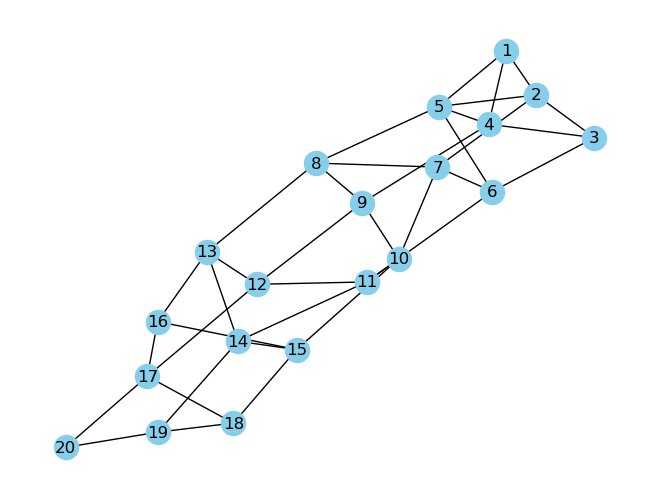

In [4]:
nx.draw(network_data["G"], node_color='skyblue', with_labels=True)
plt.savefig("plots/graph_n20.pdf")

In [5]:
f_star, x_opt_star = min_cvx_quad_constraint(problem_spec, problem_data, True)

unconstrained_f_star, unconstrained_x_opt_star = min_cvx_quad_constraint(problem_spec, problem_data, False)
if (f_star, x_opt_star) == (unconstrained_f_star, unconstrained_x_opt_star):
    print("Constraints have no meaning")
else:
    print("Constraints have meaning")

print(f"{f_star=}, {np.linalg.norm(x_opt_star)=}")

Constraints have meaning
f_star=2.194846759437718, np.linalg.norm(x_opt_star)=0.3135937994184583


In [6]:
Q = problem_data['Q']
p = problem_data['p']
 
vector_size = problem_spec['vector_size']
n_node = problem_spec['n_node']
prox_operators = []
grad_h = []
f_plus_h = []

# Define functions and proximal operators to implement the method
for jj in range(n_node):
    Qj = Q[jj]
    pj = p[jj]
    aj = a[jj]
    bj = b[jj]
    prox_operators += [lambda z, rho, aj=aj, bj=bj : prox_fj_quad_constraint(z, rho, aj, bj) ]
    grad_h += [lambda z, Qj=Qj, pj=pj : grad_hj_quad_constraint(z, Qj, pj) ]
    f_plus_h += [lambda x_kj, Qj=Qj, pj=pj : 1/2 * x_kj @ Qj @ x_kj.T + np.dot(pj, x_kj) ]

In [7]:
# apply PG-EXTRA 
best_rho = 0
find_best = True
start, end, space = 0.01, 0.1, 0.005


# start, end, space = 0.01, 0.15, 0.01
# start, end, space = 0.1, 0.3, 0.01

best_value = 1

if find_best == True:
    for r in np.arange(start, end, space) :
        problem_data['rho'] = round(r, 2)
        pg_op_norm, pg_err_opt_star, pg_err_opt_reldiff, pg_const_vio, pg_f_reldiff = co.pg_extra("pg_extra", problem_spec, problem_data, 
                                                                        network_data, x_opt_star, f_star, prox_operators=prox_operators,
                                                                        grad_h=grad_h, f_plus_h=f_plus_h,
                                                                        printing=False, freq=200)
        new_val = sum(pg_f_reldiff[300:400]) / 100
        if new_val < best_value:
            print("new best_rho :", round(r, 2),  "new best_value :", new_val)
            best_value = new_val
            best_rho = round(r, 2)

print("best_rho :", best_rho)

new best_rho : 0.01 new best_value : 6.397972770451587e-05
new best_rho : 0.02 new best_value : 1.7755258793932352e-06
new best_rho : 0.03 new best_value : 1.6543004574129075e-08
new best_rho : 0.04 new best_value : 3.9914750981240095e-10
new best_rho : 0.05 new best_value : 3.7655123978318574e-11
best_rho : 0.05


In [8]:
problem_data['rho'] = best_rho

pg_op_norm, pg_err_opt_star, pg_err_opt_reldiff, pg_const_vio, pg_f_reldiff = co.pg_extra("pg_extra", problem_spec, problem_data, 
                                                                        network_data, x_opt_star, f_star, prox_operators=prox_operators,
                                                                        grad_h=grad_h, f_plus_h=f_plus_h,
                                                                        printing=True, freq=200)

ii=0, f_reldiff[-1]=0.9002983179989965, err_opt_reldiff[-1]=0.8956452780077516
ii=200, f_reldiff[-1]=1.572662986768964e-07, err_opt_reldiff[-1]=6.188406470907703e-07
ii=400, f_reldiff[-1]=7.417515761908603e-13, err_opt_reldiff[-1]=3.877285496453255e-12
ii=600, f_reldiff[-1]=0.0, err_opt_reldiff[-1]=1.1185561023317607e-14
ii=800, f_reldiff[-1]=2.0233267217426633e-16, err_opt_reldiff[-1]=1.237954074176232e-14
ii=999, f_reldiff[-1]=0.0, err_opt_reldiff[-1]=1.392963933036344e-14


In [9]:
# problem_data['rho'] = 0.08
problem_data['rho'] = 0.07
# problem_data['rho'] = 0.035

pg_worse_op_norm, pg_worse_err_opt_star, pg_worse_err_opt_reldiff, pg_worse_const_vio, pg_worse_f_reldiff = co.pg_extra("pg_extra", problem_spec, problem_data, 
                                                                        network_data, x_opt_star, f_star, prox_operators=prox_operators,
                                                                        grad_h=grad_h, f_plus_h=f_plus_h,
                                                                        printing=True, freq=200)

ii=0, f_reldiff[-1]=0.917028633176678, err_opt_reldiff[-1]=0.8959053207128286


ii=200, f_reldiff[-1]=9.99242876812205e-06, err_opt_reldiff[-1]=8.510545095689455e-05
ii=400, f_reldiff[-1]=7.531366737879686e-09, err_opt_reldiff[-1]=6.41460038649565e-08
ii=600, f_reldiff[-1]=5.6766454505212165e-12, err_opt_reldiff[-1]=4.8348397469235236e-11
ii=800, f_reldiff[-1]=4.451318787833859e-15, err_opt_reldiff[-1]=3.740784073075133e-14
ii=999, f_reldiff[-1]=2.0233267217426633e-16, err_opt_reldiff[-1]=1.2517737157735002e-14


In [11]:
# params={"R":0.25, "Capacitance":0.11, "h":1}
# params={"R":0.07, "Capacitance":0.5, "h":1.1}
# params={"R":0.08, "Capacitance":1, "h":1}


# params={"R":0.035, "Capacitance":0.4, "h":0.8}  # theta=0.5

# params={"R":0.05, "Capacitance":0.35, "h":0.8} # theta=0.1

params={"R":0.07, "Capacitance":0.3, "h":0.8}  # seems best for the case step_size_C_inv -> step_size_C_inv * R_matrix[jj][ll]
# params={"R":0.065, "Capacitance":2.5, "h":0.75}  # seems best for the case step_size_C_inv -> step_size_C_inv / R_matrix[jj][ll]



pg_c_op_norm, pg_c_err_opt_star, pg_c_err_opt_reldiff, pg_c_const_vio, pg_c_f_reldiff = co.pg_extra("pg_extra_par_c", problem_spec, problem_data, 
                                                                        network_data, x_opt_star, f_star, prox_operators=prox_operators,
                                                                        grad_h=grad_h, f_plus_h=f_plus_h,
                                                                        params=params, printing=True, sc_index_set = sc_index_set, freq=200)

ii=0, f_reldiff[-1]=0.917028633176678, err_opt_reldiff[-1]=0.8959053207128286
ii=200, f_reldiff[-1]=2.9599424665124937e-09, err_opt_reldiff[-1]=3.34556122674985e-08
ii=400, f_reldiff[-1]=0.0, err_opt_reldiff[-1]=1.7047195756204788e-15
ii=600, f_reldiff[-1]=0.0, err_opt_reldiff[-1]=8.7586993806722095e-16
ii=800, f_reldiff[-1]=4.0466534434853266e-16, err_opt_reldiff[-1]=8.975475295549095e-16
ii=999, f_reldiff[-1]=2.0233267217426633e-16, err_opt_reldiff[-1]=8.850622920851206e-16


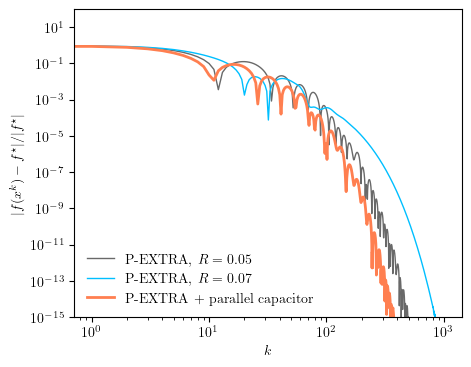

In [12]:
fname = "n20_qp_constraint_circuit_pg_c"

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams["legend.fontsize"] = 10
plt.rcParams["lines.linewidth"] = 2
plt.rcParams["lines.markersize"] = 4
plt.rcParams["legend.framealpha"] = 0.0
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10
plt.rcParams["mathtext.fontset"] = 'cm' 
black, red, blue, green = 'dimgrey', 'coral', 'deepskyblue', 'green'

# operator norm plot (log-log plot)
plt.figure(figsize=(5,4))
plt.minorticks_off()
plt.xscale("log")
plt.yscale("log")
plt.plot(pg_f_reldiff, label='P-EXTRA, $R=0.05$', color=black, linewidth=1)
plt.plot(pg_worse_f_reldiff, label='P-EXTRA, $R=0.07$', color=blue, linewidth=1)
plt.plot(pg_c_f_reldiff, label='P-EXTRA + parallel capacitor',  color=red, linewidth=2)
plt.xlabel(r"$k$")
plt.ylabel(r"$|f(x^k) - f^\star|/|f^\star|$")
plt.ylim(1e-15, 1e+2)
# plt.autoscale(enable=True, axis='y', tight=None)
plt.legend()
plt.savefig(f'plots/freldif_{fname}.pdf', dpi=300)

In [13]:
criterion = 10**(-8)

for i in range(len(pg_f_reldiff)):
    if pg_f_reldiff[i]<criterion:
        print(i)
        print(pg_f_reldiff[i])
        break

for i in range(len(pg_c_f_reldiff)):
    if pg_c_f_reldiff[i]<criterion:
        print(i)
        print(pg_c_f_reldiff[i])
        break

214
2.016849850573693e-09
147
8.439697184410242e-09
